In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

In [2]:
def load_metadata(filename):
    with open(filename, 'r') as f:
        return [x.strip().split('\t') for x in f.readlines()]

In [3]:
# TODO: Update this so it's not hardcoded. For prelim results, just moving quickly
interested_categories = ['n01882714', 'n04562935']

# NOTE: We can only use the training data for this since we're assuming an imbalanced input set.
interested_data = [x for x in load_metadata('./metadata_output/train_metadata.txt') if x[1] in interested_categories]

In [4]:
# Use VGG19 to extract features (trained on ImageNet)
feature_extraction = tf.keras.applications.VGG19(include_top=False, input_shape=(64,64,3))

In [5]:
feature_extraction.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [6]:
def find_representatives(images, num_representatives=5):
    all_features = feature_extraction(images)
    reshaped = np.reshape(all_features, (len(images), 2048))
    
    # Run kmeans
    kmeans = KMeans(n_clusters=num_representatives, random_state=0).fit(reshaped)
    
    # Find closest images
    representatives = pairwise_distances_argmin(kmeans.cluster_centers_, reshaped)
    
    return representatives

In [7]:
def plot_representatives(images, representatives):
    # Show representative images
    for i in representatives:
        plt.imshow(images[i])
        plt.show()

In [8]:
def save_representatives(cat, images, representatives):
    for i in representatives:
        filename = './representative_data/{}/{}.jpg'.format(cat, i)
        print('Saving to: {}'.format(filename))
        cv2.imwrite(filename, images[i] * 255.)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Representative images for category: n01882714


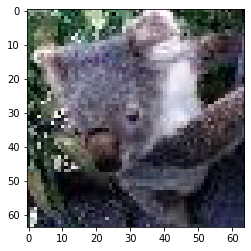

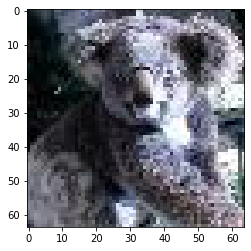

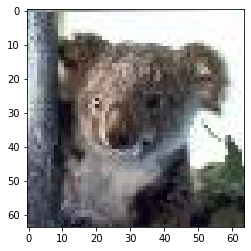

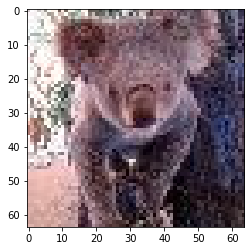

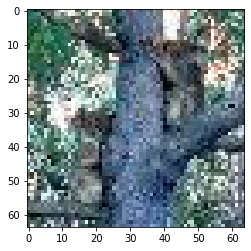

Saving representatives...
Saving to: ./representative_data/n01882714/225.jpg
Saving to: ./representative_data/n01882714/338.jpg
Saving to: ./representative_data/n01882714/21.jpg
Saving to: ./representative_data/n01882714/2.jpg
Saving to: ./representative_data/n01882714/74.jpg
Done
Representative images for category: n04562935


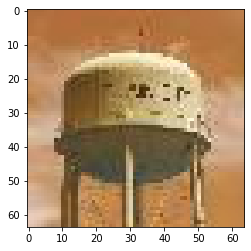

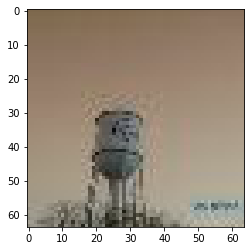

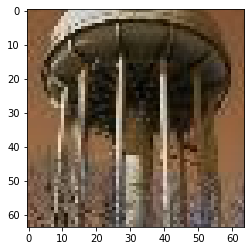

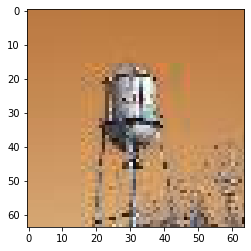

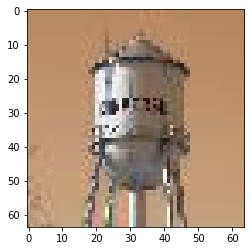

Saving representatives...
Saving to: ./representative_data/n04562935/228.jpg
Saving to: ./representative_data/n04562935/119.jpg
Saving to: ./representative_data/n04562935/298.jpg
Saving to: ./representative_data/n04562935/310.jpg
Saving to: ./representative_data/n04562935/59.jpg
Done


In [9]:
for cat in interested_categories:
    cat_data = [x[0] for x in interested_data if x[1] == cat]
    # Read tiny imagenet metadata (start with small subset)
    images = np.array([cv2.resize(cv2.imread(x), (64,64)) for x in cat_data]) / 255.
    representatives = find_representatives(images)
    print('Representative images for category: {}'.format(cat))
    plot_representatives(images, representatives)
    print('Saving representatives...')
    save_representatives(cat, images, representatives)
    print('Done')